In [2]:
import repsig
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_experiments = 10000 # num of A/B tests to simulate
n = 10000               # num samples in each A/B test

# Simulate revenue generation using zero-inflated LogNormal

In [4]:
def rev_simulate(mean, n, zero_prob=0.1, lognorm_sigma=1.):
    lognorm_mu = np.log(mean) - np.log1p(-zero_prob) - (lognorm_sigma ** 2) / 2
    rev = np.random.lognormal(lognorm_mu, lognorm_sigma, size=n)
    zero = np.random.binomial(1, 1 - zero_prob, size=n)
    return rev * zero

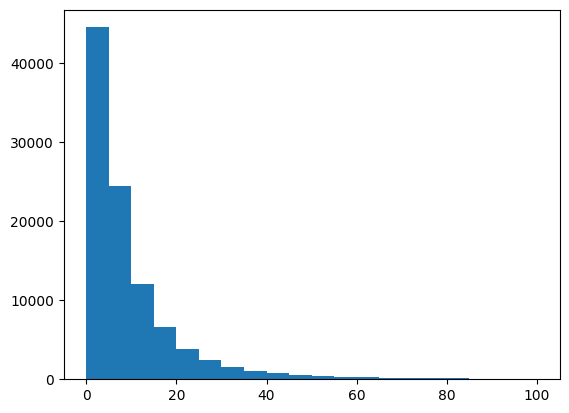

In [5]:
plt.hist(rev_simulate(mean=10, n=100000), bins=20, range=(0, 100))
plt.show()

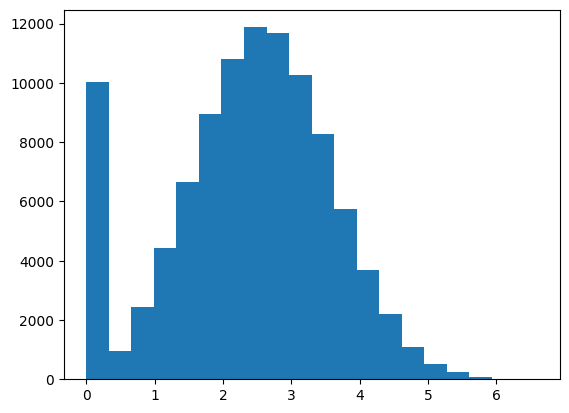

In [6]:
# plot arcsinh (similar to log, but linear near zero) to show zero-inflation
plt.hist(np.arcsinh(rev_simulate(mean=10, n=100000)), bins=20)
plt.show()

# Run A/B tests

In [7]:
def cum_moments(X, axis=-1):
    n = X.shape[axis]

    sums = np.cumsum(X, axis=axis)
    means = sums / np.arange(1, 1 + n)

    sums_square = np.cumsum(np.square(X), axis=axis)
    means_square = sums_square / np.arange(1, 1 + n)
    variances = means_square - np.square(means)
    return means, variances

In [8]:
def extract_decision_points(num_points, *arrs):
    num_samples = arrs[0].shape[0]
    random_points = np.random.choice(num_samples, num_points - 1)
    decision_points = np.r_[
        np.sort(random_points), num_samples - 1
    ]

    def yield_arrays():
        for arr in arrs:
            yield arr[decision_points]
        yield 1 + decision_points

    return tuple(yield_arrays())

In [9]:
def get_z_scores(X, Y, num_decision_points):
    means_x, vars_x, ns_x = extract_decision_points(num_decision_points, *cum_moments(X))
    means_y, vars_y, ns_y = extract_decision_points(num_decision_points, *cum_moments(Y))

    diffs = means_y - means_x
    sems = np.sqrt(vars_x / ns_x + vars_y / ns_y)
    return diffs / sems

In [10]:
x_mean_revenue = 3
y_mean_revenue = 3
num_decision_points = 28   # t in the paper
repetition_fraction = 0.1  # u in the paper
best_w = 1 - np.exp(-1/num_decision_points) # optimal w for geometric spending, in the paper

false_rejects = 0
for i in range(num_experiments):
    # simulate revenue-generating event, and extract z-scores
    X = rev_simulate(x_mean_revenue, n)
    Y = rev_simulate(y_mean_revenue, n)
    z_scores = get_z_scores(X, Y, num_decision_points)

    # use repsig.ztest_with_repetitions for the z-test
    rejected = repsig.ztest_with_repetitions(
        z_scores,
        repsig.auto_geo_budget(num_decision_points, num_decision_points / 2),
        repsig.frac_repetitions(num_decision_points))
    if rejected:
        false_rejects += 1

print(f'False rejects = {false_rejects}/{num_experiments}, which are {false_rejects / num_experiments:.2%}')

False rejects = 395/10000, which are 3.95%
